In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import Request, urlopen
from IPython.display import Markdown as md

%matplotlib inline

# Data explorations

(c) Carlos Contreras, August 2021

## Load data

In [2]:
df_comor = pd.read_csv('../../data/AHS/Restricted/demo_comorb_cdom.csv', true_values=["Yes"])
df_hosps = pd.read_csv('../../data/AHS/Restricted/hosps.csv')
df_comor['Year_Month'] = pd.to_datetime(df_comor['Year_Month'], format='%Y_%m')

In [3]:
md("""The data is contained in two datasets:

- `demo_comorb_cdom`: contains personal information, COVID-19 infection information, comorbidities, and symptoms.
  - Number of entries: {}
  - Number of features: {}
  - Observations range: {} to {}
- `hosps`: hospitalizations (one patient can be admited more than once) with admission and discharge days, and ICU, ventilation and death flags.
  - Number of observations: {}
  - Number of features: {}
  - Several patients ({}) have been admitted more than once to the hospital. The count of unique values in `demo_comorb_cdom` and `hosps` coincide.
""".format(df_comor.shape[0],
           df_comor.shape[1],
           min(df_comor['Year_Month']).strftime("%B %Y"),
           max(df_comor['Year_Month']).strftime("%B %Y"),
           df_hosps.shape[0],
           df_hosps.shape[1],
           sum(df_hosps.pivot_table(columns=['PHN_ENC'], aggfunc='size').value_counts()[1:])))

The data is contained in two datasets:

- `demo_comorb_cdom`: contains personal information, COVID-19 infection information, comorbidities, and symptoms.
  - Number of entries: 5270
  - Number of features: 55
  - Observations range: March 2020 to January 2021
- `hosps`: hospitalizations (one patient can be admited more than once) with admission and discharge days, and ICU, ventilation and death flags.
  - Number of observations: 5883
  - Number of features: 7
  - Several patients (536) have been admitted more than once to the hospital. The count of unique values in `demo_comorb_cdom` and `hosps` coincide.


In [4]:
pd.DataFrame(df_hosps.pivot_table(columns=['PHN_ENC'], aggfunc='size').value_counts(), 
             columns=['Number of patients admited once or more'])

,Number of patients admited once or more
1,4734
2,472
3,52
4,11
5,1


## Featured variables

- Number of comorbidities.
- Number of symptoms, including symptoms listed in other.
- Dead flag: 1 (True) if death days is non-empty (greather than zero)
- Number of hospitalizations

In [5]:
df_comor['Num. comorbidities'] = df_comor.iloc[:, 4:20].sum(axis=1)
df_comor['Num. symptoms'] = df_comor.iloc[:, 22:53].sum(axis=1) + \
                             df_comor.iloc[:, 54].str.split(',').apply(lambda x: len(x) if type(x)==list else 0)
df_comor['Num. symptoms'] = df_comor['Num. symptoms'].astype(int)
df_hosps['Dead flag'] = (df_hosps.Death_days >= 0)
df_comor['Age group'] = pd.cut(df_comor['age'], bins=[0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, np.inf], 
                               right=True, include_lowest=True,
                               labels=['Under 1 year', '1-4 years', '5-9 years', '10-19 years',
                                       '20-29 years', '30-39 years', '40-49 years', '50-59 years',
                                       '60-69 years', '70-79 years', '80+ years'])
# number of hospitalizations
df_numhosps = pd.DataFrame(df_hosps.pivot_table(columns=['PHN_ENC'], aggfunc='size'), columns=['NUM_HOSPS'])
df_numhosps.reset_index(inplace=True)

Merged data frame. Each entry corrresponds to one hospitalization and personal information is thus duplicated in cases with multiple hospitalizations. This means each entry is considered a separate patient. **(WARNING: duplication bias?)**

In [6]:
df = pd.merge(df_comor, pd.merge(df_hosps, df_numhosps, on='PHN_ENC'), on='PHN_ENC')

In [7]:
idx = list(range(4,20))+[61, 62]
df.iloc[:, idx] = df.iloc[:, idx].astype('bool')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5883 entries, 0 to 5882
Data columns (total 66 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   PHN_ENC                           5883 non-null   int64         
 1   age                               5883 non-null   float64       
 2   Year_Month                        5883 non-null   datetime64[ns]
 3   Sex                               5879 non-null   object        
 4   MI                                5883 non-null   bool          
 5   CHF                               5883 non-null   bool          
 6   PVD                               5883 non-null   bool          
 7   CEVD                              5883 non-null   bool          
 8   Dementia                          5883 non-null   bool          
 9   CPD                               5883 non-null   bool          
 10  Rheumatic                         5883 non-null 

In [8]:
df.describe(include=['bool', 'object', 'category']).transpose()

,count,unique,top,freq
Sex,5879,3,M,3236
MI,5883,2,False,5654
CHF,5883,2,False,5370
PVD,5883,2,False,5784
CEVD,5883,2,False,5691
Dementia,5883,2,False,5386
CPD,5883,2,False,5150
Rheumatic,5883,2,False,5824
PUD,5883,2,False,5796
MILDLD,5883,2,False,5670


In [9]:
df.describe(include=['int', 'float'])

,PHN_ENC,age,Num. comorbidities,Num. symptoms,Admit_days,Disch_days,LOS,Death_days,NUM_HOSPS
count,5.883000e+03,5883.000000,5883.000000,5883.000000,5883.000000,5883.000000,5883.000000,1183.000000,5883.000000
mean,1.663953e+11,63.463132,1.011729,3.227775,-0.038756,-17.914329,17.875574,17.519019,1.239334
std,9.203752e+10,20.502035,1.141337,2.934997,26.873642,19.988448,35.161479,16.972191,0.538712
min,4.071224e+08,0.000000,0.000000,0.000000,-59.000000,-268.000000,0.000000,0.000000,1.000000
25%,8.371498e+10,50.158904,0.000000,1.000000,-6.000000,-21.000000,4.000000,7.000000,1.000000
50%,1.752195e+11,66.246575,1.000000,3.000000,-1.000000,-12.000000,8.000000,13.000000,1.000000
75%,2.446224e+11,79.536986,2.000000,5.000000,1.000000,-7.000000,18.000000,22.000000,1.000000
max,3.231289e+11,144.021918,8.000000,21.000000,1076.000000,0.000000,1079.000000,146.000000,5.000000


## Exclusions

- Two (2) entries have age greater than 140. Unrealistic: removing from the table.

In [10]:
print("Number of entries (original): ", df.shape[0])
# Incorrect age entries
print("\nSorted values of age:")
print(df.age.sort_values(ascending=False).head())
df.drop(df[df['age'] >= 140].index, inplace=True)
print("\nEntries remaining: ", df.shape[0])
# Multiple hospitalizations?
# df.drop(df[df['Dead_flag'] & df['NUM_HOSPS']>2].index, inplace=True)

Number of entries (original):  5883

Sorted values of age:
5330    144.021918
528     143.997260
2057    104.934247
1480    103.320548
2831    103.136986
Name: age, dtype: float64

Entries remaining:  5881


## Charts and plots 

,Count,Percentage
Sex,,
Male,3236,55.02
Female,2641,44.91


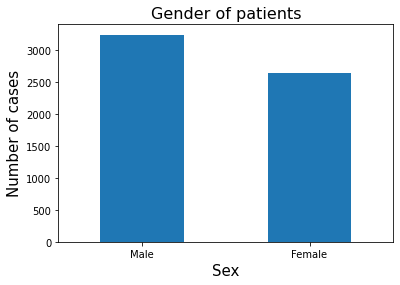

In [35]:
df_temp = df
temp = df_temp['Sex'].value_counts()
temp = temp.rename(index={"M":"Male", "F": "Female"})
temp.index.name = "Sex"
temp.plot.bar()
plt.xlabel("Sex", fontsize=15)
plt.ylabel("Number of cases", fontsize=15)
plt.title("Gender of patients", fontsize=16)
plt.xticks(rotation=0)
pd.DataFrame({'Count':temp, 'Percentage':(temp/len(df_temp)*100).round(2)})

,Count,Percentage
Age group,,
Under 1 year,30,0.51
1-4 years,16,0.27
5-9 years,5,0.09
10-19 years,88,1.50
20-29 years,290,4.93
30-39 years,454,7.72
40-49 years,579,9.85
50-59 years,868,14.76
60-69 years,1001,17.02


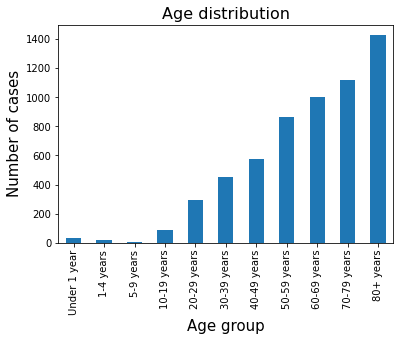

In [38]:
df_temp = df
temp = df_temp['Age group'].value_counts()
temp = temp.reindex(index=df_comor['Age group'].cat.categories.values)
temp.index.name = "Age group"
temp.plot.bar()
plt.xlabel("Age group", fontsize=15)
plt.ylabel("Number of cases", fontsize=15)
plt.title("Age distribution", fontsize=16)
pd.DataFrame({'Count':temp, 'Percentage':(temp/len(df_temp)*100).round(2)})

Sex,Female,Male
Age group,,
Under 1 year,9,21
1-4 years,8,8
5-9 years,2,3
10-19 years,41,47
20-29 years,181,109
30-39 years,234,220
40-49 years,247,331
50-59 years,361,506
60-69 years,376,624


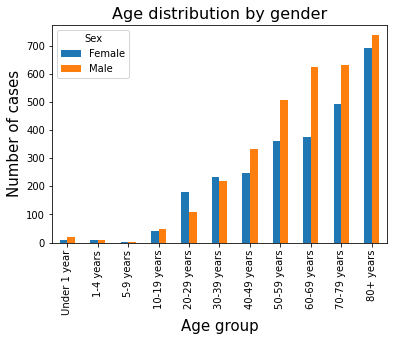

In [39]:
temp = df.groupby('Sex')['Age group'].value_counts().unstack(0)
temp = temp.reindex(index=df_comor['Age group'].cat.categories.values)
temp = temp.rename(columns={"M":"Male", "F": "Female"})
temp.plot.bar()
plt.xlabel("Age group", fontsize=15)
plt.ylabel("Number of cases", fontsize=15)
plt.title("Age distribution by gender", fontsize=16)
temp

In [15]:
temp = df.iloc[:, 4:20].sum()
temp = temp.rename(index={"MI": "Myocardial infarction",
                        "CHF": "Congestive Heart Failure",
                        "PVD": "Peripheral Vascular Disease",
                        "CEVD": "Cerebrovascular Disease",
                        "Dementia": "Dementia",
                        "CPD": "Chronic Pulmonary Disease",
                        "Rheumatic": "Rheumatic Disease",
                        "PUD": "Peptic Ulcer Disease",
                        "MILDLD": "Liver disease – mild",
                        "DIAB_UC": "Diabetes without complications",
                        "DIAB_C": "Diabetes with complications",
                        "Paraplegia": "Paraplegia and Hemiplegia",
                        "RD": "Renal Disease",
                        "Cancer": "Cancer",
                        "MSLD": "Metastatic Carcinoma",
                        "METS": "Liver disease – moderate/severe"})
temp.index.name = "Comorbidity"
pd.DataFrame({'Count':temp, 'Percent':(temp/len(df)*100).round(2)})

,Count,Percent
Comorbidity,,
Myocardial infarction,229,3.89
Congestive Heart Failure,513,8.72
Peripheral Vascular Disease,99,1.68
Cerebrovascular Disease,192,3.26
Dementia,497,8.45
Chronic Pulmonary Disease,733,12.46
Rheumatic Disease,59,1.00
Peptic Ulcer Disease,87,1.48
Liver disease – mild,213,3.62


,Count,Percentage
Num. comorbidities,,
0,2390,40.64
1,1975,33.58
2,889,15.12
3,409,6.95
4,149,2.53
5,48,0.82
6,12,0.20
7,8,0.14
8,1,0.02


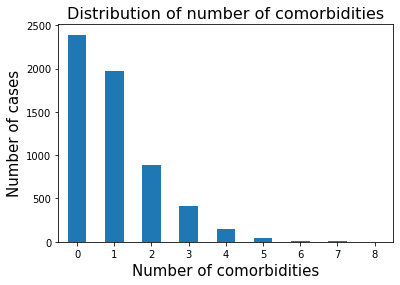

In [40]:
df_temp = df
temp = df_temp['Num. comorbidities'].value_counts()
temp.index.name = "Num. comorbidities"
temp.plot.bar()
plt.xlabel("Number of comorbidities", fontsize=15)
plt.ylabel("Number of cases", fontsize=15)
plt.title("Distribution of number of comorbidities", fontsize=16)
plt.xticks(rotation=0)
pd.DataFrame({'Count':temp, 'Percentage':(temp/len(df_temp)*100).round(2)})

In [17]:
def counttable(df):
    def Count(x):
        return x
    def Percent(x):
        return (x/x.sum()*100).round(2)
    temp = df.apply([Count, Percent], axis=0)
    return temp.append(pd.Series(temp.sum(), name='Total'))

Ventilation             ICU            Dead        
             Count Percent   Count Percent   Count Percent
Sex                                                       
Female       256.0   35.85   379.0   35.45   469.0   39.68
Male         458.0   64.15   690.0   64.55   713.0   60.32
Total        714.0  100.00  1069.0  100.00  1182.0  100.00

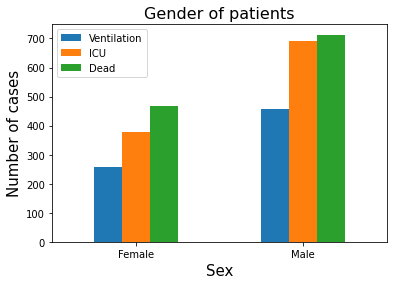

In [41]:
temp = df[['Vent_flag', 'ICU_flag', 'Dead flag', 'Sex']].groupby('Sex').agg(sum)
temp = temp.rename(columns={'Vent_flag':'Ventilation', 'ICU_flag':"ICU", 'Dead flag':'Dead'},
                   index={'M':'Male', 'F':'Female'})
temp.plot.bar()
plt.xlabel("Sex", fontsize=15)
plt.xticks(rotation=0)
plt.ylabel("Number of cases", fontsize=15)
plt.title("Gender of patients", fontsize=16)
counttable(temp)

Ventilation             ICU            Dead        
                   Count Percent   Count Percent   Count Percent
Age group                                                       
Under 1 year         3.0    0.42    14.0    1.31     1.0    0.08
1-4 years            1.0    0.14     4.0    0.37     0.0    0.00
5-9 years            1.0    0.14     1.0    0.09     0.0    0.00
10-19 years          3.0    0.42     8.0    0.75     0.0    0.00
20-29 years         27.0    3.78    38.0    3.55     4.0    0.34
30-39 years         33.0    4.62    54.0    5.05    10.0    0.85
40-49 years         79.0   11.06   131.0   12.25    14.0    1.18
50-59 years        151.0   21.15   224.0   20.95    80.0    6.77
60-69 years        204.0   28.57   292.0   27.32   172.0   14.55
70-79 years        164.0   22.97   227.0   21.23   304.0   25.72
80+ years           48.0    6.72    76.0    7.11   597.0   50.51
Total              714.0   99.99  1069.0   99.98  1182.0  100.00

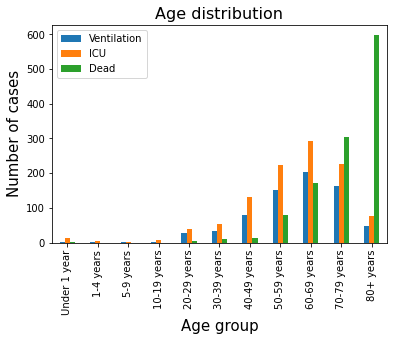

In [42]:
temp = df[['Vent_flag', 'ICU_flag', 'Dead flag', 'Age group']].groupby('Age group').agg(sum)
temp = temp.rename(columns={'Vent_flag':'Ventilation', 'ICU_flag':"ICU", 'Dead flag':'Dead'})
temp.index = temp.index.astype('object')
temp.plot.bar()
plt.xlabel("Age group", fontsize=15)
plt.ylabel("Number of cases", fontsize=15)
plt.title("Age distribution", fontsize=16)
counttable(temp)

Female           Male        
              Count Percent  Count Percent
Age group                                 
Under 1 year    1.0    0.21    NaN     NaN
1-4 years       NaN     NaN    NaN     NaN
5-9 years       NaN     NaN    NaN     NaN
10-19 years     NaN     NaN    NaN     NaN
20-29 years     4.0    0.85    NaN     NaN
30-39 years     5.0    1.07    5.0    0.70
40-49 years     6.0    1.28    8.0    1.12
50-59 years    30.0    6.40   50.0    7.01
60-69 years    62.0   13.22  110.0   15.43
70-79 years   109.0   23.24  195.0   27.35
80+ years     252.0   53.73  345.0   48.39
Total         469.0  100.00  713.0  100.00

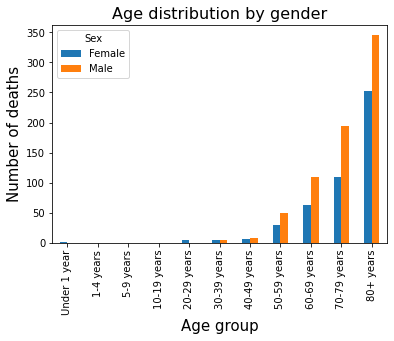

In [43]:
temp = df[df['Dead flag']].groupby('Sex')['Age group'].value_counts().unstack(0)
temp = temp.reindex(index=df_comor['Age group'].cat.categories.values)
temp = temp.rename(columns={"M":"Male", "F": "Female"})
temp.plot.bar()
plt.xlabel("Age group", fontsize=15)
plt.ylabel("Number of deaths", fontsize=15)
plt.title("Age distribution by gender", fontsize=16)
counttable(temp)

array([6., 4.])

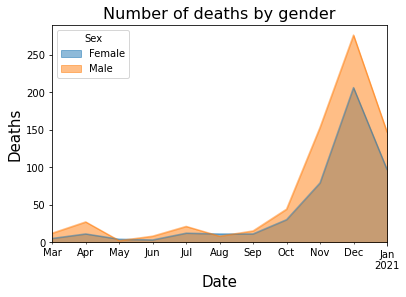

In [127]:
temp = df[df['Dead flag']].groupby('Sex')['Year_Month']
temp = temp.value_counts().unstack(0).sort_index().fillna(0).fillna(method="pad")
temp = temp.rename(columns={"M":"Male", "F": "Female"})
temp.plot.area(stacked=False)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Deaths', fontsize=15)
plt.title("Number of deaths by gender", fontsize=16);
plt.gcf().get_size_inches()

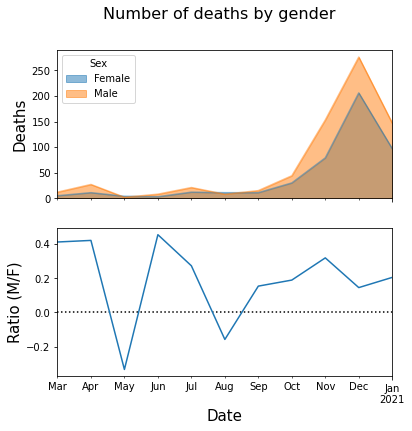

In [138]:
temp = df[df['Dead flag']].groupby('Sex')['Year_Month']
temp = temp.value_counts().unstack(0).sort_index().fillna(0).fillna(method="pad")
temp = temp.rename(columns={"M":"Male", "F": "Female"})
fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
temp.plot.area(stacked=False, ax=ax[0])
ax[0].set_ylabel('Deaths', fontsize=15)
temp1 = (temp['Male'] - temp['Female'])/(temp['Male'] + temp['Female'])
temp1.plot(ax=ax[1])
plt.hlines(0, temp1.index.values.min(), temp1.index.values.max(), linestyle='dotted', color='black')
ax[1].set_xlabel('Date', fontsize=15)
ax[1].set_ylabel('Ratio (M/F)', fontsize=15);
fig.suptitle("Number of deaths by gender", fontsize=16);